# Visualize Model Training Results

#### SELECT MODEL/RUN ID

**Notable IDs**:

With 3 classes = ['Daphnia', 'Calanoid_1', 'Cyclopoid_1']
- `20250612_214359_densenet121_trainaug5`: Sofia's original results
- `20250616_111455_densenet121`: first 3 classes, lr = 0.0005, 40 epochs
- `20250616_122155_densenet121`: first 3 classes, lr = 0.001, 35 epochs

With 8 classes = ['Bosmina_1', 'Calanoid_1', 'Chironomid', 'Chydoridae', 'Cyclopoid_1', 'Daphnia', 'Herpacticoida', 'Nauplii']
- `20250616_130817_densenet121`: 8 classes, lr = 0.001, 40 epochs, performs poorly on classes with less samples
- `20250616_144757_densenet121`: inverse weights for loss fn, does significantly better on smaller classes, and slghtly worse on larger classes
- `20250616_145621_densenet121`: inverse normalized weights for loss fn, same as above

With max_class_size increased to 5K, each run is ~ 400sec
- `20250617_095119_densenet121`: results of HP tuning using no weights, inverse weights and normalized weights for loss fn, and lr; doesn't do great on smaller classes
- `20250617_104123_densenet121`: normalized weights for loss fn, lr = 0.0005, 40 epochs, does great on most classes except Chydoridae (1% of samples)
- `20250617_110553_densenet121`: normalized weights for loss fn and data loader sampler, worse model
- `20250617_112559_densenet121`: inverse weights for loss fn and data loader sampler, mediocre model, performs ok on all classes
- `20250617_113607_densenet121`: inverse weights for loss fn, ~ 700 sec to run, mediocre model
- `20250617_115724_densenet121`: inverse non-normalized weights for loss fn, ~ 1200 sec to run, mediocre model
- `20250617_124613_densenet121`: results of HP tuning using no weights and normalized weights for loss fn, and lr; yielded different results than first

In [1]:
# Corresponds to the desired model for displaying results.

run_name = '20250618_122437_densenet121'
run_name = '20250618_123756_densenet121'

#### Notebook & Data Set-Up

In [2]:
# Imports
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision.models as model

from sklearn.metrics import *
from sklearn.preprocessing import label_binarize

In [3]:
# Paths
data_directory = '/data/zooplankton_data'
results_directory = '/home/bushra/Analysis_zooplankton/'

weights_path = os.path.join(results_directory, 'weights', run_name + '.pth')
predictions_path = os.path.join(results_directory, 'predictions', run_name + '.pth')
metadata_path = os.path.join(results_directory, 'environment', run_name + '.pth')

In [4]:
# Load predictions
predictions = torch.load(predictions_path, map_location = torch.device('cpu'))
y_true = predictions[0].numpy()
y_pred = predictions[2].numpy()
y_pred_prob = predictions[1].numpy()

# Load environment/metadata variables
metadata = torch.load(metadata_path, weights_only = False)
model_id, model_name = metadata['model_id'], metadata['model_name']
classes, class_map = metadata['classes'], metadata['class_map']
train_metrics = metadata['train_metrics']
hyperparameters = metadata['hyperparameters']

#### Model Run Details

In [5]:
print(f'Selected Model: {model_name} (ID: {model_id})')
print('\nClasses:\n ' + '\n '.join(f'{cln}: {clid}' for cln, clid in class_map.items()))
print('\nTraining Parameters:\n ' + '\n '.join(f'{p}: {pv}' for p, pv in hyperparameters.items()))

Selected Model: densenet121 (ID: 20250618_123756)

Classes:
 Bosmina_1: 0
 Calanoid_1: 1
 Chironomid: 2
 Chydoridae: 3
 Cyclopoid_1: 4
 Daphnia: 5
 Herpacticoida: 6
 Nauplii: 7

Training Parameters:
 loss_fn: {'type': 'CrossEntropyLoss', 'weights': tensor([0.2558, 0.2597, 0.0800, 0.0062, 0.2561, 0.0239, 0.0853, 0.0331])}
 optimizer: Adam
 lr: 0.0005
 epochs: 40
 scheduler: {'type': 'StepLR', 'step_size': 10, 'gamma': 0.1}
 early_stopping: {'patience': 10, 'delta': 0.005}


#### Training Metrics

Training stopped early after 39 epochs.


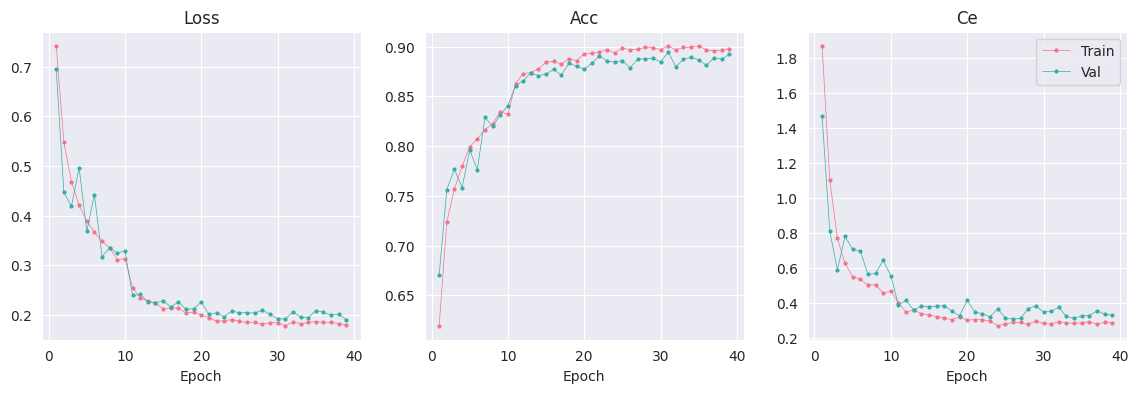

In [6]:
epochs = hyperparameters['epochs']
actual_epochs = len(train_metrics['train_acc'])

# Number of Epochs
if actual_epochs < epochs:
    epochs_enum = list(range(1, actual_epochs+1))
    print(f'Training stopped early after {actual_epochs} epochs.')
else:
    epochs_enum = list(range(1, epochs+1))

sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 3, figsize = (14, 4), sharex = True)
palette = sns.color_palette('husl', n_colors = 2)

metrics = ['loss', 'acc', 'ce']

for i, metric in enumerate(metrics):
    train_values = train_metrics[f'train_{metric}']
    val_values = train_metrics[f'test_{metric}']

    if metric == 'acc':
        val_values = [x / 100 for x in val_values]

    axes[i].plot(epochs_enum, train_values, label = f'Train', marker = 'o', markersize = 2, lw = 0.5, color = palette[0])
    axes[i].plot(epochs_enum, val_values, label = f'Val', marker = 'o', markersize = 2, lw = 0.5, color = palette[1])
    
    axes[i].set_title(metric.capitalize())
    axes[i].set_xlabel('Epoch')
    
plt.legend()
plt.show()


#### Performance Metrics

In [7]:
test_acc = accuracy_score(y_pred, y_true)
test_prec = precision_score(y_pred, y_true, average = 'weighted')
test_recall = recall_score(y_pred, y_true, average = 'weighted')
test_f1 = f1_score(y_pred, y_true, average = 'weighted')

print(f'Accuracy: {test_acc:.4f}\nWeighted Precision: {test_prec:.4f}\nWeighted Recall: {test_recall:.4f}\nWeighted F1: {test_f1:.4f}')

Accuracy: 0.8905
Weighted Precision: 0.9147
Weighted Recall: 0.8905
Weighted F1: 0.8978


/home/bushra/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


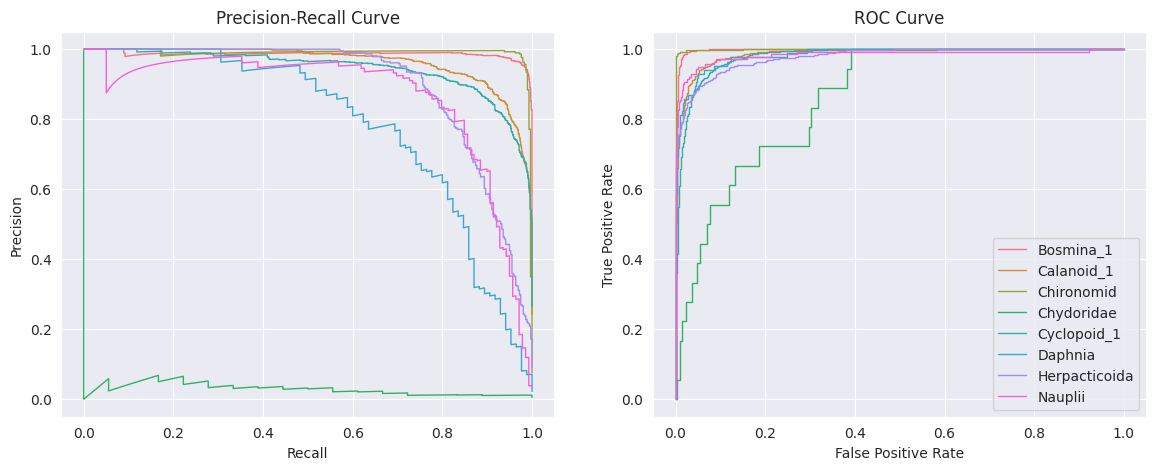

In [8]:
y_true_OHE = label_binarize(y_true, classes = list(class_map.values())) # one hot encoded

sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize = (14, 5))
palette = sns.color_palette('husl', n_colors = len(class_map))

for (cln, clid), col in zip(class_map.items(), palette):
    precision, recall, _ = precision_recall_curve(y_true_OHE[:, clid], y_pred_prob[:, clid])
    axs[0].plot(recall, precision, label = f'{cln}', lw = 1, color = col)

    fpr, tpr, _ = roc_curve(y_true_OHE[:, clid], y_pred_prob[:, clid])
    axs[1].plot(fpr, tpr, label = f'{cln}', lw = 1, color = col)

axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall Curve')

axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve')

plt.legend(loc = 'best')
plt.show()

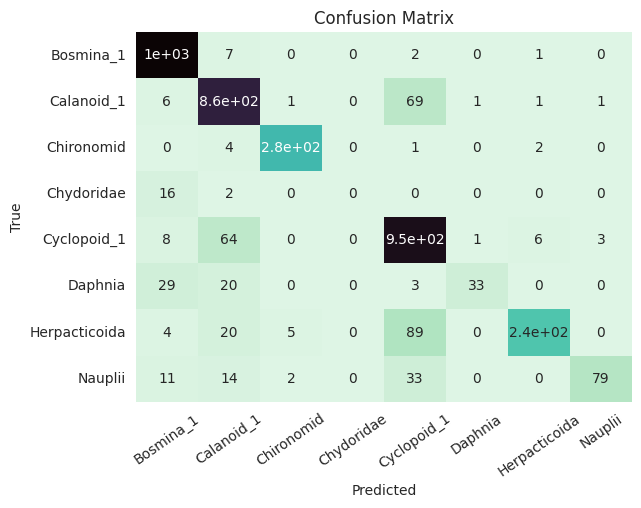

In [9]:
# Get confusion matrix data
cm = confusion_matrix(y_true, y_pred)

# Plot
sns.heatmap(cm, annot = True, cmap = 'mako_r', xticklabels = classes, yticklabels = classes, cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation = 35)

# plt.tight_layout()
plt.show()

/tmp/ipykernel_1220207/4185002405.py:2: RuntimeWarning: invalid value encountered in divide
  cm_col_percent = cm / cm.sum(axis = 0, keepdims = True)


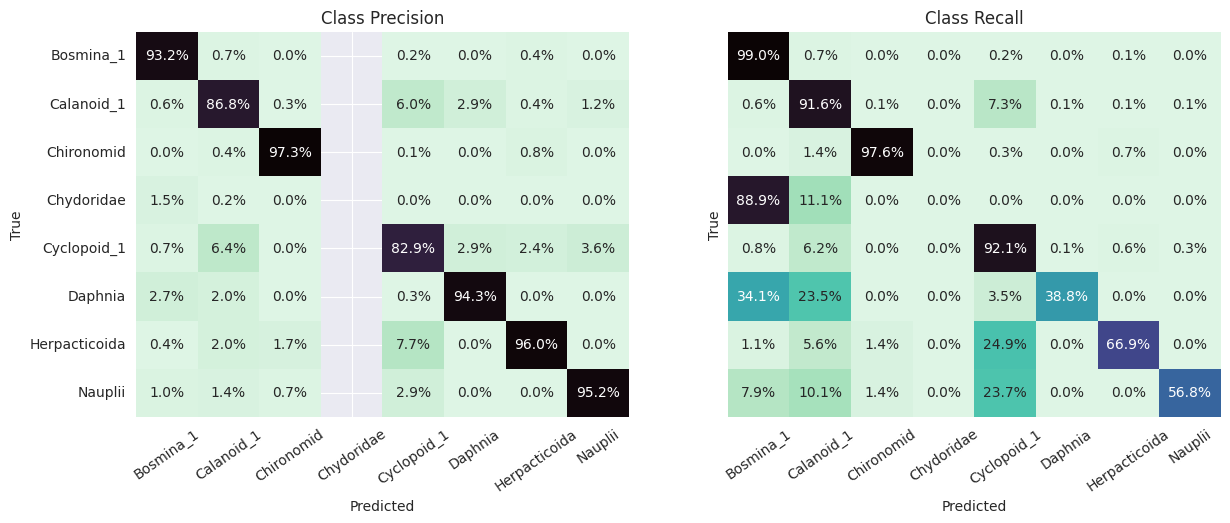

In [10]:
# Get confusion matrix data
cm_col_percent = cm / cm.sum(axis = 0, keepdims = True)
annot_col = np.array([[f"{val:.01%}" for val in row] for row in cm_col_percent])

cm_row_percent = cm / cm.sum(axis = 1, keepdims = True)
annot_row = np.array([[f"{val:.01%}" for val in col] for col in cm_row_percent])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey = True)

sns.heatmap(cm_col_percent, annot = annot_col, fmt = '', cmap = 'mako_r', xticklabels = classes, yticklabels = classes, cbar = False, ax = axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Class Precision')
axs[0].tick_params(axis = 'x', rotation = 35)

sns.heatmap(cm_row_percent, annot = annot_row, fmt = '', cmap = 'mako_r', xticklabels = classes, yticklabels = classes, cbar = False, ax = axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Class Recall')
axs[1].tick_params(axis = 'x', rotation = 35)

plt.show()